In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost
from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (make_scorer, 
                            accuracy_score, 
                            roc_auc_score)
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from my_awesome_eda import run_eda
from sklearn.pipeline import make_pipeline

In [34]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

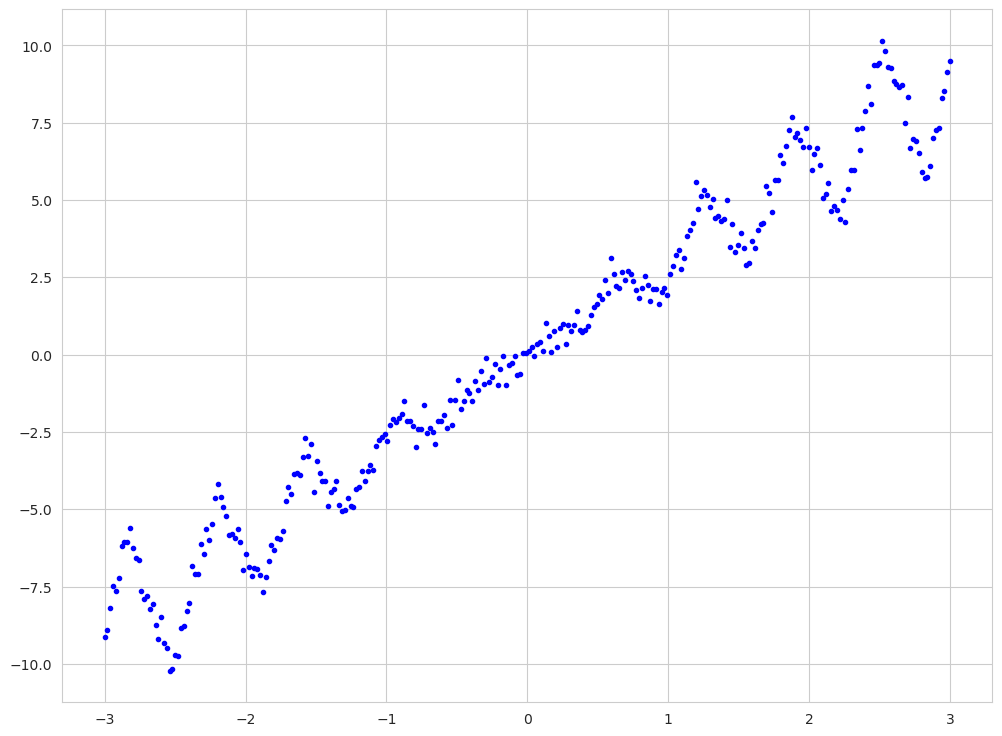

In [35]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [36]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, depth, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$" + f"_{depth}")
    plt.legend()

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

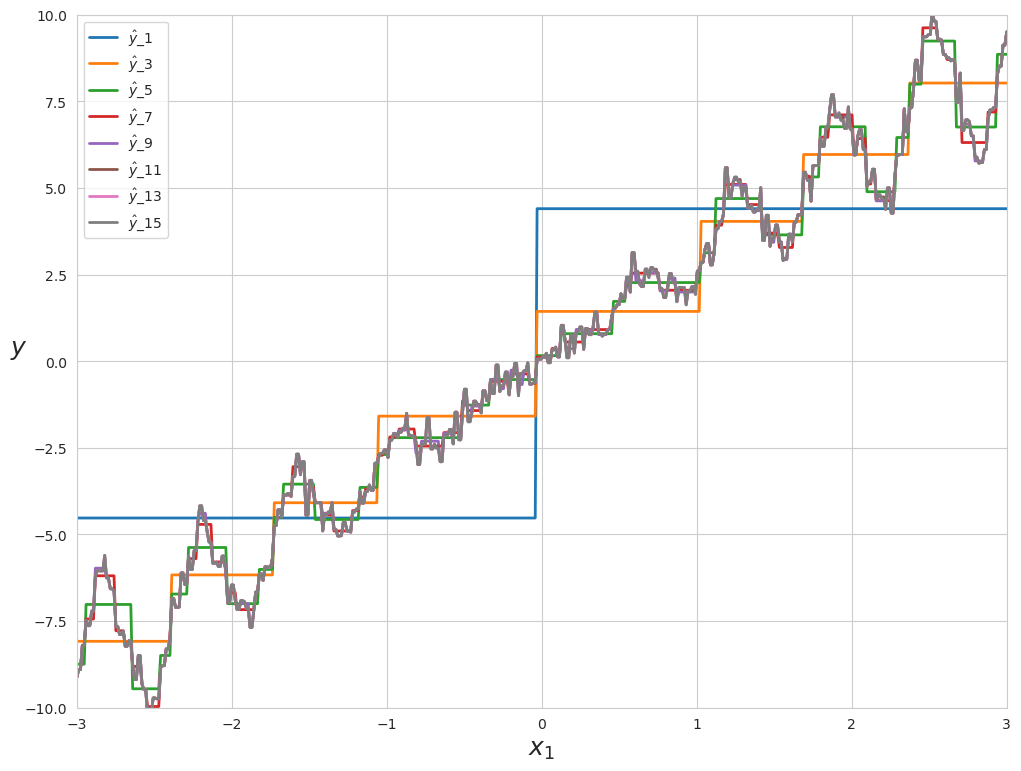

In [37]:
models_depth = {}

for depth in [1, 3, 5, 7, 9, 11, 13, 15]:

    models_depth[f"DT_depth{depth}"] = DecisionTreeRegressor(max_depth=depth,
                                                             random_state=42)
    models_depth[f"DT_depth{depth}"].fit(X,y)
    plot_regression_predictions(models_depth[f"DT_depth{depth}"], depth, X, y, axes=[-3, 3, -10, 10], ylabel="$y$")

Видно, что при малой глубине (1, 3) у модели высокий bias - она недообучена. С повышением глубины получаем более обученную модель - ломанная захватывает всё большее количество точек. Беда в том, что с повышением вэрианса мы переобучаемся - по картинке видно, модель как будто "пытается" пройти через все точки трейна. Я бы сказал, что оптимальной была бы глубина 7. Общий паттерн хорошо выучен, но при этом модель не пытается упорно воспроизвести трейн)   

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [38]:
means = []
probs = [x / 100 for x in range(2, 100, 2)]
for prob in probs:
    mean = 0
    for i in range(51,102):
        mean += np.sum(math.comb(101, i) * prob**i * (1-prob)**(101-i))
    means.append(mean)

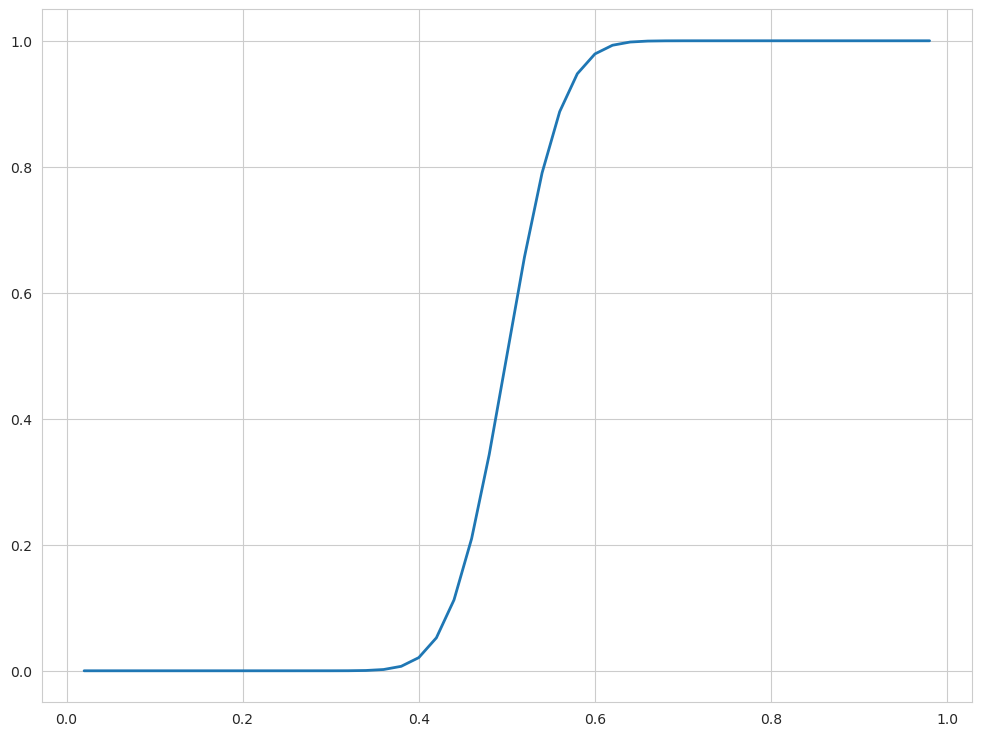

In [39]:
plt.plot(probs, means, linewidth=2);

Здравствуй, Сигмоида :)

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [40]:
means = []
prob = 0.65
for i in range(1, 100):
    mean = 0
    j = i // 2 + 1
    for k in range(j,i+1):
        mean += np.sum(math.comb(i, k) * prob**k * (1-prob)**(i-k))
    means.append(mean)

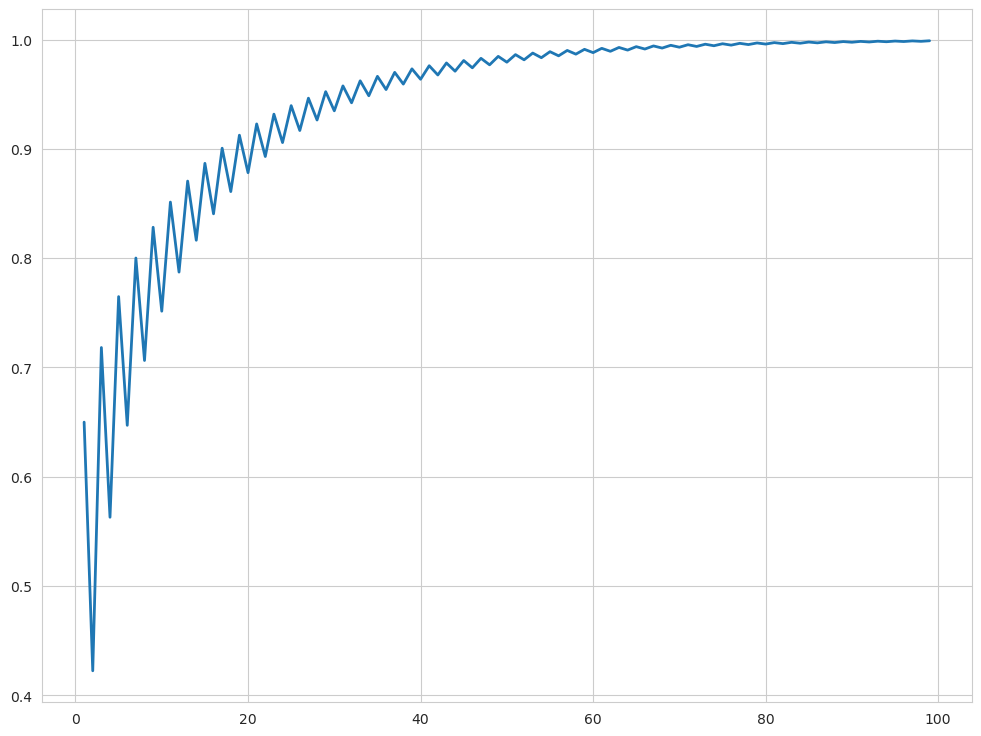

In [41]:
plt.plot(list(range(1,100)), means, linewidth=2);

Опишите ваши наблюдения:

* Вероятность предсказания в общем растёт, поскольку мы скдадываем всё больше значений. В какой-то момент так или иначе выйдем на плато. Выше единицы не прыгнешь :) 
* Однако же мы растём скачкообразно, потому что, например, для 1ой модели нам необходим 1 успех. А для 2х моделей 2 успеха. Вероятность двух успехов меньше чем вероятность одного. Потому вероятность предсказания упала. Когда у нас 3 модели, то это уже 3\*0.65^2\*0.35. Снова растём. Для четырёх - 4\*0.65^3\*0.35, и это меньше, чем для трёх, снова вероятность упала. И так далее, растём, падаем, растём, падаем - через одну. Но общий тренд (через две итерации числа классификаторов) - всегда растём. 

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [42]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        n_features = np.shape(X)[1]
        n_objects = np.shape(X)[0]
        for i in range(self.n_estimators):
            np.random.seed(self.random_state + i)
            features_indeces = np.random.choice(
                n_features, self.max_features, replace=False
            )
            train_indeces = np.random.choice(
                n_objects, n_objects, replace=True
            )
            tree = DecisionTreeClassifier(max_depth=self.max_depth,
                                          max_features=self.max_features)
            tree.fit(X[train_indeces][:, features_indeces], y[train_indeces])
            self.feat_ids_by_tree.append(features_indeces)
            self.trees.append(tree)
        return self

    def predict_proba(self, X):
        probas = np.zeros((X.shape[0], len(self.classes_)))
        for features, tree in zip(self.feat_ids_by_tree, self.trees):
            y_pred = tree.predict_proba(X[:, features])
            probas += y_pred
            probas /= self.n_estimators
        return probas

    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [43]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

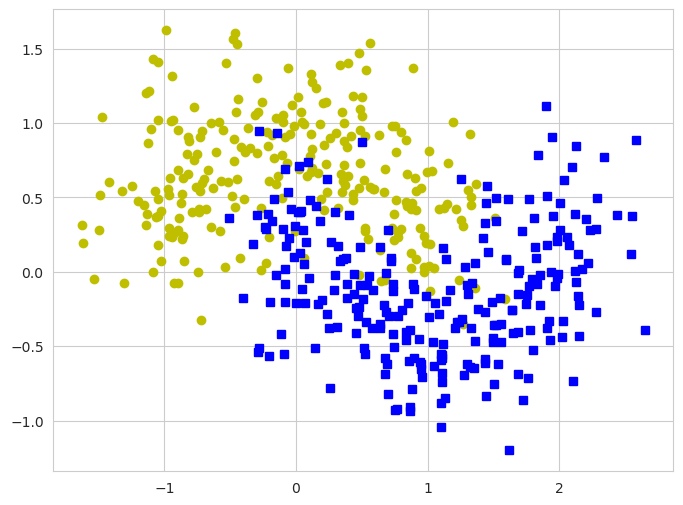

In [44]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

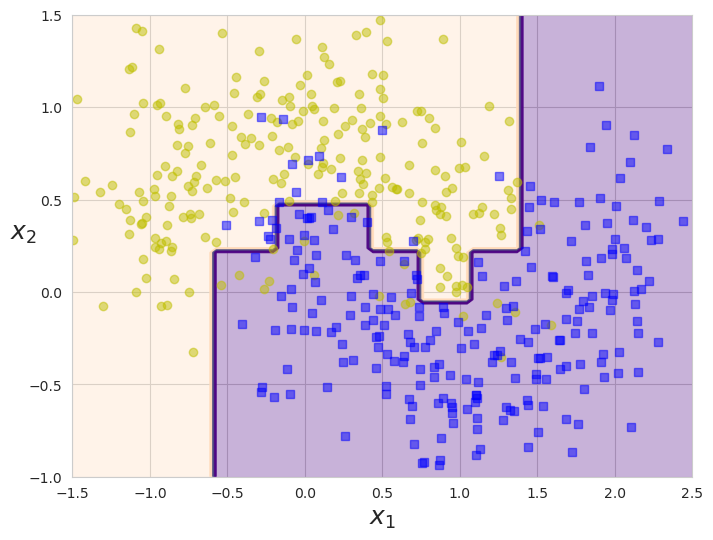

In [45]:
plt.figure(figsize=(8, 6))
clf = RandomForestClassifierCustom(n_estimators=50, max_depth=6, max_features=2, random_state=SEED)
clf.fit(X, y)
plot_decision_boundary(clf, X, y)
# plt.title(f"Decision border, max_depth = {max_depth}, n_estimators = {n_estimators}", fontsize=14)
plt.show()

Выглядет неплохо, оценим качество полученной модели с использованными параметрами:

Метрики тоже показали неплохой результат, посмотрим, можно ли лучше

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
scoring = {'accuracy': make_scorer(accuracy_score), 'roc_auc': make_scorer(roc_auc_score)}
model = RandomForestClassifierCustom()
grid_search = GridSearchCV(model,
                          {"max_depth": list(range(2, 20, 2)),
                           "n_estimators": list(range(5, 50, 5)),
                           "max_features": [1,2]}, 
                          scoring=scoring, refit='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifierCustom(), n_jobs=150,
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': [1, 2],
                         'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 45]},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'roc_auc': make_scorer(roc_auc_score, response_method='predict')})

In [48]:
print("Best Parameters:", grid_search.best_params_)
print("Accuracy Score:", accuracy_score(y_test, grid_search.predict(X_test)))
print("ROC AUC:", roc_auc_score(y_test, grid_search.predict_proba(X_test)[:, 1]))

Best Parameters: {'max_depth': 6, 'max_features': 2, 'n_estimators': 35}
Accuracy Score: 0.896
ROC AUC: 0.9511538461538461


Чуть повысили метрики, отрисуем границу:

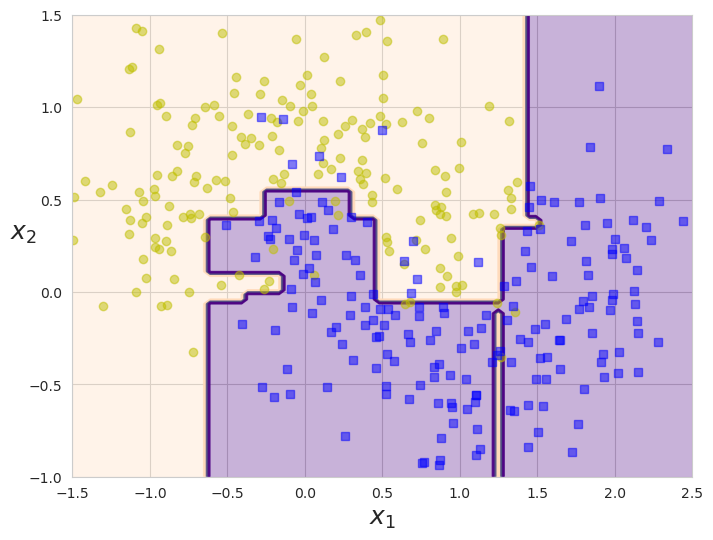

In [49]:
plt.figure(figsize=(8, 6))
clf = grid_search.best_estimator_
clf.fit(X_train, y_train)
plot_decision_boundary(clf, X_train, y_train)
# plt.title(f"Decision border, max_depth = {max_depth}, n_estimators = {n_estimators}", fontsize=14)
plt.show()

Наблюдается небольшой разрыв в синем полотне, но теперь более строго определяем синие квадраты на границе с жёлтой областью 

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [50]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [51]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [53]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
corrs = []
for max_features in range(1, 31):
    rf_model = RandomForestClassifier(max_features=max_features, n_jobs=150)
    rf_model.fit(X_train, y_train)
    corrs.append(base_model_pair_correlation(rf_model, X_test))

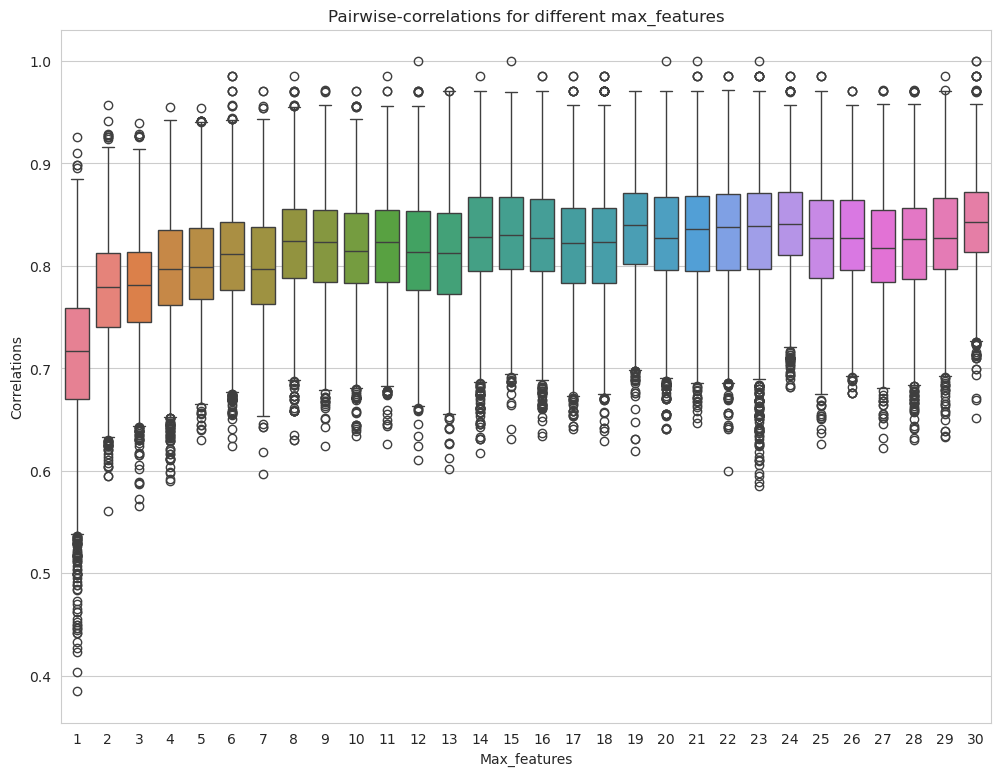

In [54]:
sns.boxplot(corrs)
plt.xticks(range(0, len(corrs)), labels=range(1, len(corrs) + 1)) 
plt.xlabel('Max_features')
plt.ylabel('Correlations')
plt.title('Pairwise-correlations for different max_features')
plt.show()

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [31]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
max_depth_corrs = []
for max_depth in range(5, 100, 5):
    rf_model = RandomForestClassifier(max_depth=max_depth)
    rf_model.fit(X_train, y_train)
    max_depth_corrs.append(base_model_pair_correlation(rf_model, X_test))

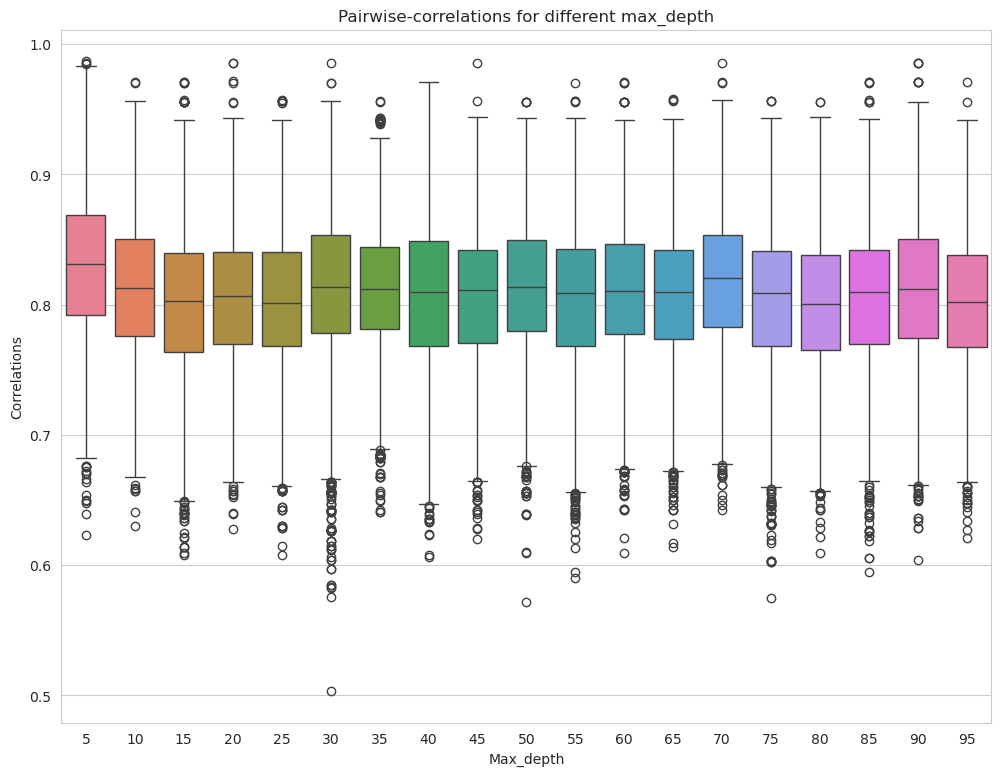

In [43]:
sns.boxplot(max_depth_corrs)
plt.xticks(range(0, len(max_depth_corrs)), labels=range(5, 100, 5))  # Label each boxplot
plt.xlabel('Max_depth')
plt.ylabel('Correlations')
plt.title('Pairwise-correlations for different max_depth')
plt.show()

Опишите ваши наблюдения:

* При увеличении max_features с одного до двух корреляция возрастает (не статистически значимо, вероятно, но тем не менее), однако тут же и выходит на плато.
* Держу пари, что если бы я взял max_depth с единицы и с меньшим шагом, увидел бы также возрастающую корелляцию, которая уже при 5 выходит на плато, как это показано на боксплоте выше
* Обобщая, можно сказать, что с какого-то момента (max_features > 2, max_depth > 5), увеличение max_depth и max_features не искажает картину резким увеличением корреляции предсказаний деревьев для данного случая 

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [55]:
# !gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("../data/heart.csv")

In [56]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [57]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(verbosity = -1, random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(verbosity = -1, boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [58]:
import warnings
warnings.filterwarnings('ignore')

In [59]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
voting_soft = VotingClassifier(base_models, voting='soft')
voting_hard = VotingClassifier(base_models, voting='hard')
## END YOUR CODE HERE ##

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528


TBB Warning: The number of workers is currently limited to 31. The request for 71 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.8281746031746032
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.8134522115571786
LGBMClassifier: 0.817010631644778
XGBRFClassifier: 0.8499478840942256
LGBMClassifier: 0.8132478632478634
LogisticRegression: 0.8500073681108163
GaussianNB: 0.8140676625250128
VotingClassifier: 0.8494440278941667
VotingClassifier: 0.8455110375195781


Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [60]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [61]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
voting_hard.fit(X_train, y_train)
corrs_hard = base_model_pair_correlation_for_voting_clf(voting_hard, X_test)
voting_soft.fit(X_train, y_train)
corrs_soft = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)

In [62]:
def Sort(sub_li):
    sub_li.sort(key = lambda x: x[2], reverse = True)
    return sub_li
corrs_soft = Sort(corrs_soft)

In [63]:
for estimator_1, estimator_2, value in corrs_soft:
    print(f"{estimator_1.__class__.__name__} vs {estimator_2.__class__.__name__}: {value}")

LGBMClassifier vs XGBClassifier: 0.970838692549758
CatBoostClassifier vs LGBMClassifier: 0.955278131308783
ExtraTreesClassifier vs CatBoostClassifier: 0.9527199736215165
SVC vs LogisticRegression: 0.9521510226464572
CatBoostClassifier vs XGBRFClassifier: 0.9454804718176699
RandomForestClassifier vs CatBoostClassifier: 0.9450698035153566
LGBMClassifier vs XGBRFClassifier: 0.9393402441419185
RandomForestClassifier vs XGBRFClassifier: 0.93660300972797
XGBClassifier vs XGBRFClassifier: 0.9341115110090193
CatBoostClassifier vs XGBClassifier: 0.933989657312727
LGBMClassifier vs XGBRFClassifier: 0.9318146314104276
RandomForestClassifier vs ExtraTreesClassifier: 0.9215651183028868
RandomForestClassifier vs LGBMClassifier: 0.9146873011990887
RandomForestClassifier vs LGBMClassifier: 0.9146686698479999
ExtraTreesClassifier vs XGBRFClassifier: 0.8977047690966481
RandomForestClassifier vs XGBClassifier: 0.8966406332594105
ExtraTreesClassifier vs LGBMClassifier: 0.8928745278265378
LogisticRegressio

Уф.... ну что, поиграем

In [64]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
#Уменьшим выборку моделей и будем добавлять по одной, проверять получившиеся скоры для hard и soft voting-a
base_models_new = [("DT", dt), ("LGBM_RF", lgbm_rf),
               ("XGB_RF", xgb_rf), ("NB", nb)]
base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]
model_scores = []
for model in base_models:
    base_models_new_updated = base_models_new.copy()
    if model not in base_models_new_updated:
        base_models_new_updated.append(model)
        new_voting_soft = VotingClassifier(base_models_new_updated, voting='soft')
        new_voting_hard = VotingClassifier(base_models_new_updated, voting='hard')
        model_scores.append([])
        for voting_model in [new_voting_hard, new_voting_soft]: 
            score = cross_val_score(voting_model, X_train, y_train, cv=3, scoring="f1")
            model_scores[-1].append(score.mean())
        model_scores[-1].append(model[1].__class__.__name__)
model_scores
## END YOUR CODE HERE ##

[[0.852439024390244, 0.8572009557216207, 'RandomForestClassifier'],
 [0.8588909735251198, 0.8647372738335747, 'ExtraTreesClassifier'],
 [0.8600122007015404, 0.8482496926941371, 'KNeighborsClassifier'],
 [0.8615794100823649, 0.8620691740161489, 'SVC'],
 [0.8747183857380744, 0.856102744991634, 'SVC'],
 [0.8560255222805392, 0.8573366637280831, 'CatBoostClassifier'],
 [0.8516260162601625, 0.8487621371562198, 'LGBMClassifier'],
 [0.8607723577235772, 0.8492065824272701, 'XGBClassifier'],
 [0.8608852755194217, 0.8567269076305221, 'LogisticRegression']]

Кажется, бинго)

In [65]:
base_models_new = [("DT", dt), ("LGBM_RF", lgbm_rf),
                    ("XGB_RF", xgb_rf), ("NB", nb), 
                    ("SVC_RBF", svc_rbf)]
new_voting_hard = VotingClassifier(base_models_new, voting='hard')
score = cross_val_score(new_voting_hard, X_train, y_train, cv=3, scoring="f1").mean()
print(f'My wonderful score: {score}')

My wonderful score: 0.8747183857380744


# Аллилуя!

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [66]:
data = pd.read_csv("../data/churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [67]:
run_eda(data)

Greetings, stranger! Please get acquainted with data

Number of observations: 3333
Number of parameters: 21

Categorical variables: Area Code, Int'l Plan, VMail Plan, CustServ Calls, Churn?
Numerical variables: Account Length, VMail Message, Day Mins, Day Calls, Day Charge, Eve Mins, Eve Calls, Eve Charge, Night Mins, Night Calls, Night Charge, Intl Mins, Intl Calls, Intl Charge
String variables: State, Phone

Categorical variables statistics:


,counts,frequencies
Area Code,,
415,1655,0.496550
510,840,0.252025
408,838,0.251425


,counts,frequencies
Int'l Plan,,
no,3010,0.90309
yes,323,0.09691


,counts,frequencies
VMail Plan,,
no,2411,0.723372
yes,922,0.276628


,counts,frequencies
CustServ Calls,,
1,1181,0.354335
2,759,0.227723
0,697,0.209121
3,429,0.128713
4,166,0.049805
5,66,0.019802
6,22,0.006601
7,9,0.002700
9,2,0.000600


,counts,frequencies
Churn?,,
False.,2850,0.855086
True.,483,0.144914




Numerical variables statistics:


,count,mean,std,min,25%,50%,75%,max,median,IQR
Account Length,3333.0,101.064806,39.822106,1.00,74.00,101.00,127.00,243.00,101.00,53.00
VMail Message,3333.0,8.099010,13.688365,0.00,0.00,0.00,20.00,51.00,0.00,20.00
Day Mins,3333.0,179.775098,54.467389,0.00,143.70,179.40,216.40,350.80,179.40,72.70
Day Calls,3333.0,100.435644,20.069084,0.00,87.00,101.00,114.00,165.00,101.00,27.00
Day Charge,3333.0,30.562307,9.259435,0.00,24.43,30.50,36.79,59.64,30.50,12.36
Eve Mins,3333.0,200.980348,50.713844,0.00,166.60,201.40,235.30,363.70,201.40,68.70
Eve Calls,3333.0,100.114311,19.922625,0.00,87.00,100.00,114.00,170.00,100.00,27.00
Eve Charge,3333.0,17.083540,4.310668,0.00,14.16,17.12,20.00,30.91,17.12,5.84
Night Mins,3333.0,200.872037,50.573847,23.20,167.00,201.20,235.30,395.00,201.20,68.30
Night Calls,3333.0,100.107711,19.568609,33.00,87.00,100.00,113.00,175.00,100.00,26.00


,Number of outliers
Account Length,18
VMail Message,3
Day Mins,25
Day Calls,23
Day Charge,25
Eve Mins,24
Eve Calls,20
Eve Charge,24
Night Mins,30
Night Calls,26


Number of missing values: 0
Number of duplicated rows: 0


Есть подозрение, что среди наших фичей, есть сильно скоррелированные. Например, Day ... ; Eve ... ; Night ... ; Intl ...
Проверим это!

In [68]:
num_features = ['Account Length', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 
                'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge']
corr = data[num_features].corr()
print('Таблица корреляций переменных:')
corr

Таблица корреляций переменных:


,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge
Account Length,1.000000,-0.004628,0.006216,0.038470,0.006214,-0.006757,0.019260,-0.006745,-0.008955,-0.013176,-0.008960,0.009514,0.020661,0.009546
VMail Message,-0.004628,1.000000,0.000778,-0.009548,0.000776,0.017562,-0.005864,0.017578,0.007681,0.007123,0.007663,0.002856,0.013957,0.002884
Day Mins,0.006216,0.000778,1.000000,0.006750,1.000000,0.007043,0.015769,0.007029,0.004323,0.022972,0.004300,-0.010155,0.008033,-0.010092
Day Calls,0.038470,-0.009548,0.006750,1.000000,0.006753,-0.021451,0.006462,-0.021449,0.022938,-0.019557,0.022927,0.021565,0.004574,0.021666
Day Charge,0.006214,0.000776,1.000000,0.006753,1.000000,0.007050,0.015769,0.007036,0.004324,0.022972,0.004301,-0.010157,0.008032,-0.010094
Eve Mins,-0.006757,0.017562,0.007043,-0.021451,0.007050,1.000000,-0.011430,1.000000,-0.012584,0.007586,-0.012593,-0.011035,0.002541,-0.011067
Eve Calls,0.019260,-0.005864,0.015769,0.006462,0.015769,-0.011430,1.000000,-0.011423,-0.002093,0.007710,-0.002056,0.008703,0.017434,0.008674
Eve Charge,-0.006745,0.017578,0.007029,-0.021449,0.007036,1.000000,-0.011423,1.000000,-0.012592,0.007596,-0.012601,-0.011043,0.002541,-0.011074
Night Mins,-0.008955,0.007681,0.004323,0.022938,0.004324,-0.012584,-0.002093,-0.012592,1.000000,0.011204,0.999999,-0.015207,-0.012353,-0.015180
Night Calls,-0.013176,0.007123,0.022972,-0.019557,0.022972,0.007586,0.007710,0.007596,0.011204,1.000000,0.011188,-0.013605,0.000305,-0.013630


Мануальный анализ показал, что пары:
* Day Mins, Day Charge 
* Eve Mins, Eve Charge
* Night Mins, Night Charge
* Intl Mins, Intl Charge

Имеют корреляцию > 0.99
 
В связи с этим предлагается избавиться от всех Mins, оставив при этом соответствующие Charge

Также заметим, что присутствует ряд категориальных переменных. Их перекодируем. Оставшиеся num_features не будем шкалировать, раз уж мы работаем с деревьями.

Выбросим две колонки: State и Phone. Первая как бы и категориальная, но в ней слишком много уровней (> 50). 

Можно было бы, конечно, сагрегировать States неким разумным(географическим) образом, но больно уж тяжко. 

Вторая - строковая переменная, с ней не хочется продолжать работу :)

In [69]:
data = data.drop(columns = ['Day Mins', 'Eve Mins', 'Night Mins', 'Intl Mins', 'State', 'Phone'])
cat_features = ['Area Code', "Int'l Plan", "VMail Plan", "CustServ Calls"]
data = pd.get_dummies(data, columns = ['Area Code', "Int'l Plan", "VMail Plan", "CustServ Calls"], drop_first=True)
#prefix = ['Area Code', "Int'l Plan", "VMail Plan", "CustServ Calls"], 
data.replace(False, 0, inplace = True)
data.replace(True, 1, inplace = True)
data.replace('False.', 0, inplace = True)
data.replace('True.', 1, inplace = True)
y = data['Churn?']
data = data.drop(columns = ['Churn?'])

In [70]:
X_train, X_test, y_train, y_test = train_test_split(data, y, random_state=42)

In [30]:
scoring = {'accuracy': make_scorer(accuracy_score), 'roc_auc': make_scorer(roc_auc_score)}
grid_search = GridSearchCV(RandomForestClassifier(),
                          {"max_depth": list(range(2, 20, 2)),
                           "n_estimators": list(range(5, 50, 5)),
                           "max_features": list(range(1, 24, 2))}, 
                          scoring=scoring, refit='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=100,
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                          23],
                         'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 45]},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'roc_auc': make_scorer(roc_auc_score, response_method='predict')})

In [31]:
print("RF Best Parameters:", grid_search.best_params_)
print("RF Accuracy Score:", accuracy_score(y_test, grid_search.predict(X_test)))
print("RF ROC AUC:", roc_auc_score(y_test, grid_search.predict_proba(X_test)[:, 1]))

RF Best Parameters: {'max_depth': 16, 'max_features': 19, 'n_estimators': 40}
RF Accuracy Score: 0.9460431654676259
RF ROC AUC: 0.92563610719323


Отличный результат! Попробуем реализоваться на другом алгоритме случайного леса XGBRF:

In [26]:
param_grid_xgbrf = {
    'subsample': list(x / 10 for x in range(3, 10, 2)),
    'max_depth': list(range(2, 20, 2)),
    'learning_rate': [0.01, 0.1, 0.2, 0.5],
    'n_estimators': list(range(20, 200, 20)),
}

In [27]:
scoring = {'accuracy': make_scorer(accuracy_score), 'roc_auc': make_scorer(roc_auc_score)}
grid_search_xgbrf = GridSearchCV(xgboost.XGBRFClassifier(),
                          param_grid_xgbrf, 
                          scoring=scoring, refit='accuracy')
grid_search_xgbrf.fit(X_train, y_train)

GridSearchCV(estimator=XGBRFClassifier(base_score=None, booster=None,
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bytree=None, device=None,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=None, grow_policy=None,
                                       importance_type=None,
                                       interaction_constraints=None,
                                       max_bin=None, max_cat_threshold=None,
                                       max_cat_...
                                       random_state=None, reg_alpha=None, ...),
             n_jobs=150,
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.5],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'n_estimators': [20, 40, 60, 80, 100, 120, 140, 160,
                                          180],
                         'subsample': [0.3, 0.5, 0.7, 0.9]},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'roc_auc': make_scorer(roc_auc_score, response_method='predict')})

In [28]:
print("XGBRF Best Parameters:", grid_search_xgbrf.best_params_)
print("XGBRF Accuracy Score:", accuracy_score(y_test, grid_search_xgbrf.predict(X_test)))
print("XGBRF ROC AUC:", roc_auc_score(y_test, grid_search_xgbrf.predict_proba(X_test)[:, 1]))

XGBRF Best Parameters: {'learning_rate': 0.5, 'max_depth': 12, 'n_estimators': 140, 'subsample': 0.7}
XGBRF Accuracy Score: 0.9412470023980816
XGBRF ROC AUC: 0.9207898448519041


Алгоритм сработал штатно! Но всё же чууть хуже чем реализация от skLearn)

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

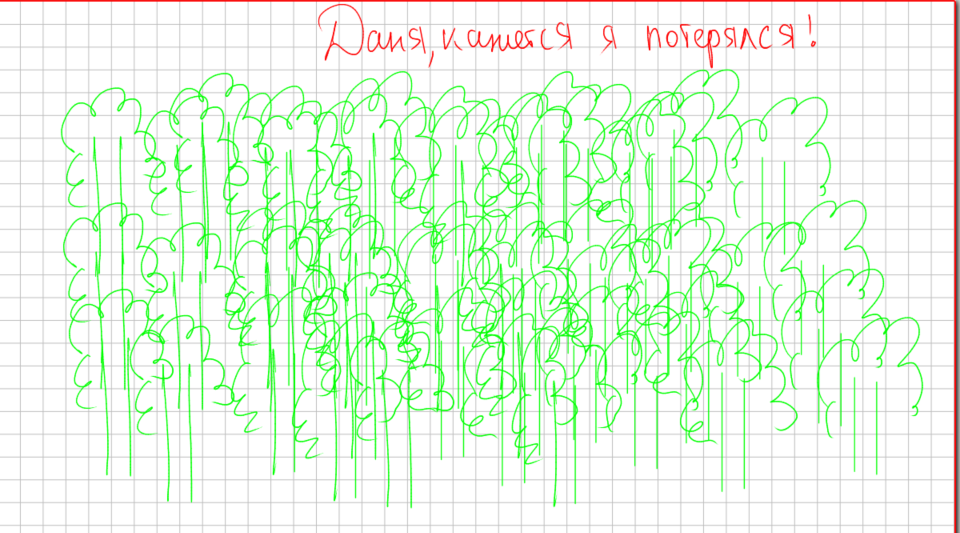

In [32]:
from IPython.display import Image
Image("../data/my_picture.png")

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

Ну конечно сидеть подстраивать часами тяжело, но итс окэй)